# Spam Email Classification

### loading data

In [1]:
from sklearn.datasets import load_files

data = load_files("emails")

In [2]:
print((data.keys()))

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])


### Train Test Split

In [3]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(data.data,data.target)


In [4]:
print("number of training data : ",len(X_train))
print("number of testing data : ",len(X_test))

number of training data :  7011
number of testing data :  2338


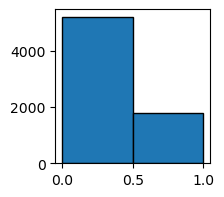

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(2,2))
plt.hist(y_train,2,edgecolor="black")
plt.show()

Data is imbalanced

### applying a simple count vectorizer

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(encoding="mac-roman")
cv.fit(X_train)

CountVectorizer(encoding='mac-roman')

In [7]:
feature_names = cv.get_feature_names_out()
print("number of features :",len(feature_names))
print("every 2000th feature :",feature_names[::4000])

number of features : 154695
every 2000th feature : ['00' '0209011641450' '1256' '1s7o7jbxj9s' '24cub2cqstifttbi' '3cdb7a8787'
 '4fqli9qdb2xclb4bgi4chr7w6tir' '6c115' '899ed16f16' 'a26683'
 'aksyiqmivsf' 'b320a16f22' 'booty' 'cert_policy' 'cracking' 'desventajas'
 'e19e6630' 'ew2ddule7tuhnhxuykplxmw3' 'fr99h29r' 'g6u6tpxx021306'
 'g8q81uc06504' 'gpr9ha6jrlp3vl8soo5v2lweeovo1dq3n3fovlo5biyvkj7yt'
 'htdig' 'incublogula' 'jnaqk1hkjzxilf8jafcexfeljwfwlwbl' 'lang_de'
 'mailpoop' 'mtc' 'nwd2mhb1' 'parton' 'pri8mfo6'
 'rb1tex7mtausoouwetbxdbn7rtzsy6qhsx9zv5ln567b' 's3mc9uvjacfc8f1'
 'smtp0582' 'taa02190' 'tweak' 'vgyvbuvrf86coefs8bmv0m'
 'wnwxn6usmj3chmujfstxhs26iuql76disiob7vytttbxe0mmseabmohbrldfn3vmbtpau'
 'yyyyais007']


most of the features seems not to be meaningful<br>
i will use min df to get rid of some codes and ...<br>
and use max df to get rid of stop words (it will be tuned later)

In [8]:
cv = CountVectorizer(encoding="mac-roman",min_df=10,max_df=50)
cv.fit(X_train)
vect_train_x = cv.transform(X_train)
feature_names = cv.get_feature_names_out()
print("number of features :",len(feature_names))

number of features : 8954


its better now

In [9]:
print("every 1000th feature :",feature_names[::1000])

every 1000th feature : ['00000' 'a12b' 'caramail' 'disclosure' 'ginger' 'lawyers' 'origin'
 'retention' 'takemeoff']


### applying a simple Log Reg

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

vect_test_x = cv.transform(X_test)
log_reg = LogisticRegression(max_iter=10000).fit(vect_train_x,y_train)
print(f1_score(y_test,log_reg.predict(vect_test_x)))

0.9550949913644213


### analyzing logreg coefs

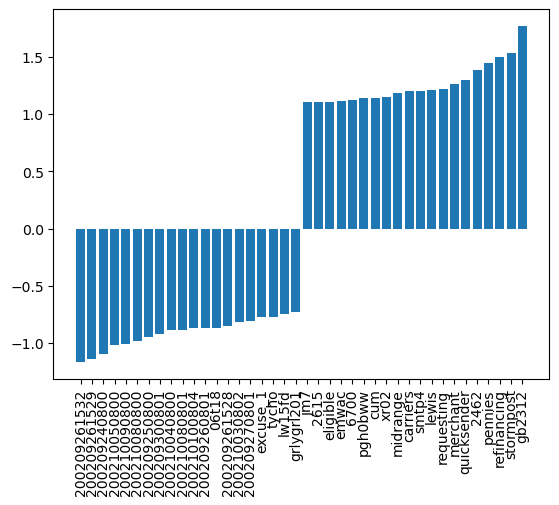

In [11]:
import numpy as np
def plot_largest_coefs(coef,feature_names):
    log_reg_coef = np.argsort(coef)
    largest_coefs =np.concatenate((log_reg_coef[:20],log_reg_coef[-20:]))
    largest_coef_values = [coef[i] for i in largest_coefs]
    largest_names = [feature_names[i] for i in largest_coefs]
    plt.bar(largest_names,largest_coef_values)
    plt.xticks(rotation=90)
    plt.show()

plot_largest_coefs(log_reg.coef_.squeeze(),feature_names)

coefs found important by log reg is saynig that some of our features seems not to be informative but we know it can perform better, i will try tf idf and then tune its parameters for better feauture extraction

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

cv = TfidfVectorizer(encoding="mac-roman",min_df=5,) # tfidf have control on word importance dont need to min and max df
cv.fit(X_train)
vect_train_x = cv.transform(X_train)
feature_names = cv.get_feature_names_out()
print("number of features :",len(feature_names))
print("every 1000th feature :",feature_names[::1000])

number of features : 21930
every 1000th feature : ['00' '200px' '41' '_yw' 'ased' 'breeds' 'collar' 'david_hamilton3' 'duwe'
 'factory' 'giants' 'hyperlinks' 'jour' 'madam' 'mutual' 'overregulation'
 'print2' 'repackage' 'serving' 'story_page' 'tnt3' 'vir']


0.9580536912751678


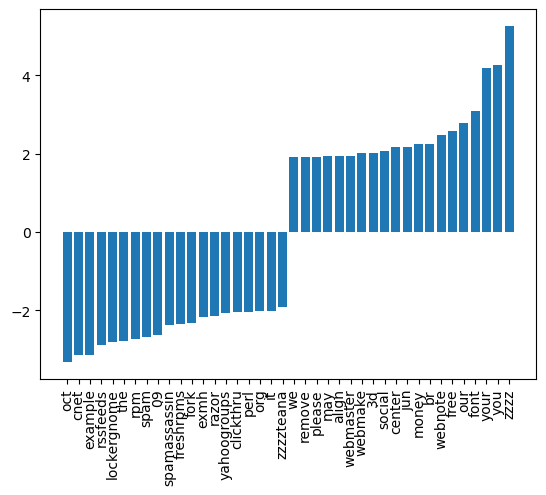

In [13]:
vect_test_x = cv.transform(X_test)
log_reg = LogisticRegression(max_iter=10000).fit(vect_train_x,y_train)
print(f1_score(y_test,log_reg.predict(vect_test_x)))
plot_largest_coefs(log_reg.coef_.squeeze(),feature_names)


good words has been found , but some tuning is still needed , i will first choose a good model for this task , sparse models should be better

In [14]:
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
from sklearn.svm import SVC

print("auc score for some models :")
print("log reg l2 :",roc_auc_score(y_test,log_reg.decision_function(vect_test_x)))

log_reg_l1 = LogisticRegression(penalty="l1",solver='liblinear')
log_reg_l1.fit(vect_train_x,y_train)
print("log reg l1 :",roc_auc_score(y_test,log_reg_l1.decision_function(vect_test_x)))

bnb = BernoulliNB()
bnb.fit(vect_train_x.toarray(),y_train)
print("bernoulli naive bayes :",roc_auc_score(y_test,bnb.predict_proba(vect_test_x.toarray())[:,1]))

mnb = MultinomialNB()
mnb.fit(vect_train_x.toarray(),y_train)
print("multinomial naive bayes :",roc_auc_score(y_test,mnb.predict_proba(vect_test_x.toarray())[:,1]))

svc = SVC(kernel="poly")
svc.fit(vect_train_x,y_train)
print("svm with poly kernel:",roc_auc_score(y_test,svc.decision_function(vect_test_x)))

svc = SVC(kernel="rbf")
svc.fit(vect_train_x,y_train)
print("svm with rbf kernel:",roc_auc_score(y_test,svc.decision_function(vect_test_x)))



auc score for some models :
log reg l2 : 0.9970076637216907


log reg l1 : 0.9954966155015883
bernoulli naive bayes : 0.9893689021668278
multinomial naive bayes : 0.9805166940108153
svm with poly kernel: 0.999020794673123
svm with rbf kernel: 0.9994566370441055


with this auc scores we can feel safe about imbalanced data , these models can handle it .<br>
best model is svm (rbf kernel) with 99.94 auc but it's slower than others, feature extraction might help to get a good accuracy with l2 logreg

### finding best tfidf params (will help to find good features)

In [15]:
params = {"tfidfvectorizer__min_df":[5,10,20],"tfidfvectorizer__ngram_range":[(1,3),(1,4),(1,5)]}

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

pipe = make_pipeline(TfidfVectorizer(encoding="mac-roman"),LogisticRegression(max_iter=10000))
grid = GridSearchCV(pipe,param_grid=params,cv=2)
grid.fit(X_train,y_train)
print("best params :",grid.best_params_)
print("best score :",grid.best_score_)

best params : {'tfidfvectorizer__min_df': 5, 'tfidfvectorizer__ngram_range': (1, 5)}
best score : 0.974326424722892


with this tfidf setting we achived very much better than the simple count vectorizer<br>
min df 5 and ngram (1,5) works well, lets decide between svm and logreg (increasing ngram range more than this is expensive !)

In [16]:
best_min_df,best_ngram = grid.best_params_["tfidfvectorizer__min_df"] ,grid.best_params_["tfidfvectorizer__ngram_range"] 
pipe = make_pipeline(TfidfVectorizer(encoding="mac-roman",min_df=best_min_df,ngram_range=best_ngram),
                     SVC(kernel="rbf"))
pipe.fit(X_train,y_train)
print("svm score :",pipe.score(X_test,y_test))
print("svm train score :",pipe.score(X_train,y_train))


svm score : 0.9927288280581694
svm train score : 0.9985736699472257


99.3 acc achived,svm with rbf is much better than log reg, lets tune svm<br>
train score is 0.999 which says that we are kinda overfitting<br>
you can see that pipeline resulted in 2 minute , so grid 2*2 with cv 2 will take around 16 mins (bigger grid or cross val will take long)<br>
i avoid grid searching , increasing gamma should do something but first i reduce c very little to reduce overfitting and get a better result

### finding best svm params

In [24]:
pipe = make_pipeline(TfidfVectorizer(encoding="mac-roman",min_df=best_min_df,ngram_range=best_ngram),
                     SVC(kernel="rbf",C=0.85))
pipe.fit(X_train,y_train)
print("svm score :",pipe.score(X_test,y_test))
print("svm train score :",pipe.score(X_train,y_train))

svm score : 0.9927288280581694
svm train score : 0.9980031379261161


it seems we reduced overfitting , lets try to reduce more with gamma

In [26]:
pipe = make_pipeline(TfidfVectorizer(encoding="mac-roman",min_df=best_min_df,ngram_range=best_ngram),
                     SVC(kernel="rbf",C=0.85,gamma=0.85))
pipe.fit(X_train,y_train)
print("svm score :",pipe.score(X_test,y_test))
print("svm train score :",pipe.score(X_train,y_train))

svm score : 0.9923011120615911
svm train score : 0.9975752389102839


now model is underfitting , increasing gamma or c , will cause overfitting<br>
so it seems we are on best setting.<br>
final result is :

In [27]:
from sklearn.metrics import classification_report

pipe = make_pipeline(TfidfVectorizer(encoding="mac-roman",min_df=best_min_df,ngram_range=best_ngram),
                     SVC(kernel="rbf",C=0.85))
pipe.fit(X_train,y_train)
print(classification_report(y_test,pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1739
           1       0.99      0.98      0.99       599

    accuracy                           0.99      2338
   macro avg       0.99      0.99      0.99      2338
weighted avg       0.99      0.99      0.99      2338



99% f1 score achived

In [28]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test,pipe.predict(X_test)))

[[1731    8]
 [   9  590]]


very small FN and FP .